In [396]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [329]:
df = pd.read_csv('Ethereum Historical Data.csv')

In [330]:
df = df.iloc[::-1].reset_index(drop=True)
df[:5]

,Date,Price,Open,High,Low,Vol.,Change %
0,01/19/2024,"2,491.81","2,469.77","2,504.09","2,418.61",443.42K,0.89%
1,01/20/2024,"2,472.03","2,491.81","2,491.81","2,455.07",143.98K,-0.79%
2,01/21/2024,"2,457.06","2,472.04","2,481.63","2,453.48",126.52K,-0.61%
3,01/22/2024,"2,313.64","2,457.06","2,465.97","2,304.06",560.84K,-5.84%
4,01/23/2024,"2,243.74","2,313.65","2,351.18","2,169.54",750.52K,-3.02%


In [331]:
train_dates = pd.to_datetime(df['Date'])
df = df.rename(columns={"Vol.": "Volume", "Change %": "Percent_change"})

In [332]:
cols = list(df)[1:7]
cols

['Price', 'Open', 'High', 'Low', 'Volume', 'Percent_change']

In [333]:
df[cols] = df[cols].astype('string')

In [334]:
df.dtypes

Date              object
Price             string
Open              string
High              string
Low               string
Volume            string
Percent_change    string
dtype: object

Making the volume data usable by converting 'M' and 'K' to million and x1000 values, removing commmas from the numbers to convert them to float.

In [335]:
vol = []
for volume in df.Volume:
    multiplier = volume[-1]
    if multiplier == 'M':
        volume = float(volume[:-1]) * 1000000
        vol.append(volume)
    else:
        volume = float(volume[:-1]) * 1000
        vol.append(volume)
    #print(volume)


vol = pd.DataFrame(vol, dtype=float, columns={'Volume'})
df.Volume = vol.Volume


In [336]:
def remove_commas(data_frame):
    for i in range (len(data_frame)):
        data_frame[i] = data_frame[i].replace(',','')


In [337]:
remove_commas(df.Price)
remove_commas(df.Open)
remove_commas(df.High)
remove_commas(df.Low)

In [338]:
for i in range(len(df.Percent_change)):
    df.Percent_change[i] = df.Percent_change[i][:-1]

In [339]:
training_df = df[cols].astype(float)
training_df.head

<bound method NDFrame.head of        Price     Open     High      Low     Volume  Percent_change
0    2491.81  2469.77  2504.09  2418.61   443420.0            0.89
1    2472.03  2491.81  2491.81  2455.07   143980.0           -0.79
2    2457.06  2472.04  2481.63  2453.48   126520.0           -0.61
3    2313.64  2457.06  2465.97  2304.06   560840.0           -5.84
4    2243.74  2313.65  2351.18  2169.54   750520.0           -3.02
..       ...      ...      ...      ...        ...             ...
363  3307.00  3450.79  3459.88  3267.48   536740.0           -4.17
364  3472.84  3307.10  3524.96  3307.10   574060.0            5.01
365  3308.74  3472.84  3493.38  3233.53   677720.0           -4.73
366  3216.74  3308.73  3445.65  3133.37  1440000.0           -2.78
367  3282.68  3216.67  3449.78  3150.35  1260000.0            2.05

[368 rows x 6 columns]>

In [340]:
scaler = StandardScaler()
scaler = scaler.fit(training_df)
scaled_training_df = scaler.transform(training_df)

In [341]:
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(scaled_training_df) - n_future+1):
    trainX.append(scaled_training_df[i - n_past:i, 0:training_df.shape[1]])
    trainY.append(scaled_training_df[i + n_future - 1: i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

In [342]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dropout(0,2))
model.add(tf.keras.layers.Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 14, 64)            18176     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [343]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Train on 318 samples, validate on 36 samples
Epoch 1/10
318/318 [==============================] - 1s 4ms/sample - loss: 0.6339 - val_loss: 0.5112
Epoch 2/10
318/318 [==============================] - 0s 600us/sample - loss: 0.2039 - val_loss: 0.1506
Epoch 3/10
318/318 [==============================] - 0s 558us/sample - loss: 0.1233 - val_loss: 0.1176
Epoch 4/10
318/318 [==============================] - 0s 519us/sample - loss: 0.0792 - val_loss: 0.0811
Epoch 5/10
318/318 [==============================] - 0s 552us/sample - loss: 0.0666 - val_loss: 0.0643
Epoch 6/10
318/318 [==============================] - 0s 526us/sample - loss: 0.0584 - val_loss: 0.0614
Epoch 7/10
318/318 [==============================] - 0s 560us/sample - loss: 0.0512 - val_loss: 0.0636
Epoch 8/10
318/318 [==============================] - 0s 606us/sample - loss: 0.0490 - val_loss: 0.0579
Epoch 9/10
318/318 [==============================] - 0s 715us/sample - loss: 0.0493 - val_loss: 0.0540
Epoch 10/10
318/318 [

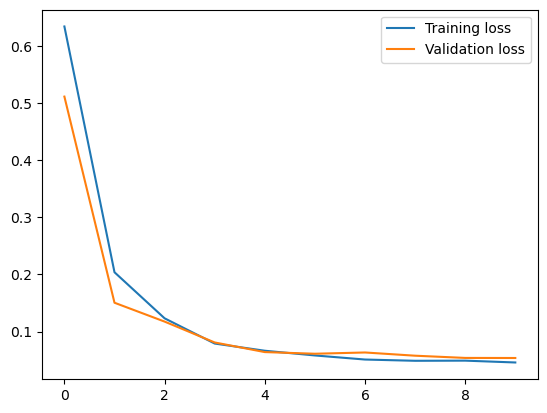

In [344]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [361]:
n_future = 7
forecast_period_dates = pd.date_range(list(train_dates)[-7], periods=n_future, freq='1d').tolist()
forecast = model.predict(trainX[-n_future:])

In [362]:
#scaling back to the original values
forecast_copies = np.repeat(forecast, training_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [363]:
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [364]:
df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [365]:
df_forecast

,Date,Open
0,2025-01-14,3151.315674
1,2025-01-15,3202.487061
2,2025-01-16,3363.982910
3,2025-01-17,3293.645508
4,2025-01-18,3410.804688
5,2025-01-19,3318.222168
6,2025-01-20,3262.749512


In [393]:
original = df[['Date', 'Open']]
original['Date'] = train_dates
original['Open'] = training_df.Open
#original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2025-01-01']

c:\Users\CAE-USER\anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\CAE-USER\anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [394]:
original
#df_forecast

,Date,Open
348,2025-01-01,3337.80
349,2025-01-02,3360.14
350,2025-01-03,3455.21
351,2025-01-04,3608.79
352,2025-01-05,3656.94
353,2025-01-06,3635.11
354,2025-01-07,3687.71
355,2025-01-08,3380.50
356,2025-01-09,3327.14
357,2025-01-10,3218.15


<AxesSubplot:xlabel='Date', ylabel='Open'>

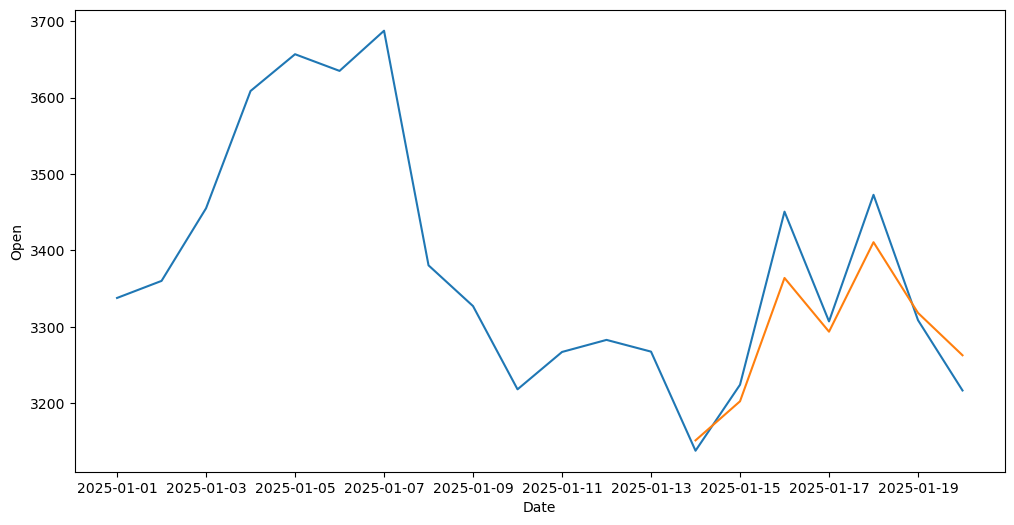

In [395]:
#sns.lineplot(original.Date, original.Open)
#sns.lineplot(df_forecast.Date, df_forecast.Open)
plt.figure(figsize=(12,6))

sns.lineplot(x='Date', y='Open', data=original)
sns.lineplot(x='Date', y='Open', data=df_forecast)